In [10]:
# download scorefiles from cluster 
! mkdir out 
! rsync -avz $ep:/share/work/alex/dnh-aro/rosetta_runs/2nd_enzdes/out/*sc out

mkdir: out: File exists
receiving file list ... done

sent 20 bytes  received 85 bytes  70.00 bytes/sec
total size is 3108727  speedup is 29606.92


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from glob import glob 

dfs = [ pandas.read_csv( i, sep='\s+' ) for i in glob( 'out/*sc' ) ]
df = pandas.concat( dfs ).dropna()
df['scaffold'] = df.description.str.split( '_' ).str.get( 4 ) 
df['match'] = df.description.str.split( '_11' ).str[0]

print len( df ), 'enzdes out'
print len( df.scaffold.unique() ), 'scaffolds'
print len( df.match.unique() ), 'unique matches'

4152 enzdes out
141 scaffolds
403 unique matches


In [12]:
# get lowest of each nstruct 

low = df.groupby( 'match' ).apply( lambda x: x.sort_values( by='total_score' ).head( 1 ) )
print len( low ), 'lowest from match groups (should equal number of matches)'

403 lowest from match groups (should equal number of matches)


In [13]:
# filter_groups = [ 
#     ( 
#         'my_filter_group', [ 
#             ( low1.all_cst < 0.05 ), 
#         ]
#      ),
#     ( 
#         'my_filter_group_2', [ 
#             ( low1.all_cst < 0.05 ),
#             ( low1.SR_1_total_score < -1 ), # Tyr
#             ( low1.SR_2_total_score < -1 ), # Glu/Asp
#             ( low1.SR_3_total_score < -3 ), # 2-allylphenol 
#             ( low1.SR_3_dsasa_1_2 > 0.7 ), # ligand burial 
#         ]
#      ),
# ]    

filtered = low[ 
    ( low.all_cst < 0.05 ) & 
    ( low.SR_1_total_score < -1 ) & # Tyr
    ( low.SR_2_total_score < -1 ) & # Glu/Asp
    ( low.SR_3_total_score < -3 ) & # 2-allylphenol 
    ( low.SR_3_dsasa_1_2 > 0.7 ) # ligand burial 
]

print len( filtered ), 'structures filtered of', len( low ), 'lowest energy'
filtered.to_csv( 'filtered.csv' )

44 structures filtered of 403 lowest energy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b67cfd0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x124156d90>]], dtype=object)

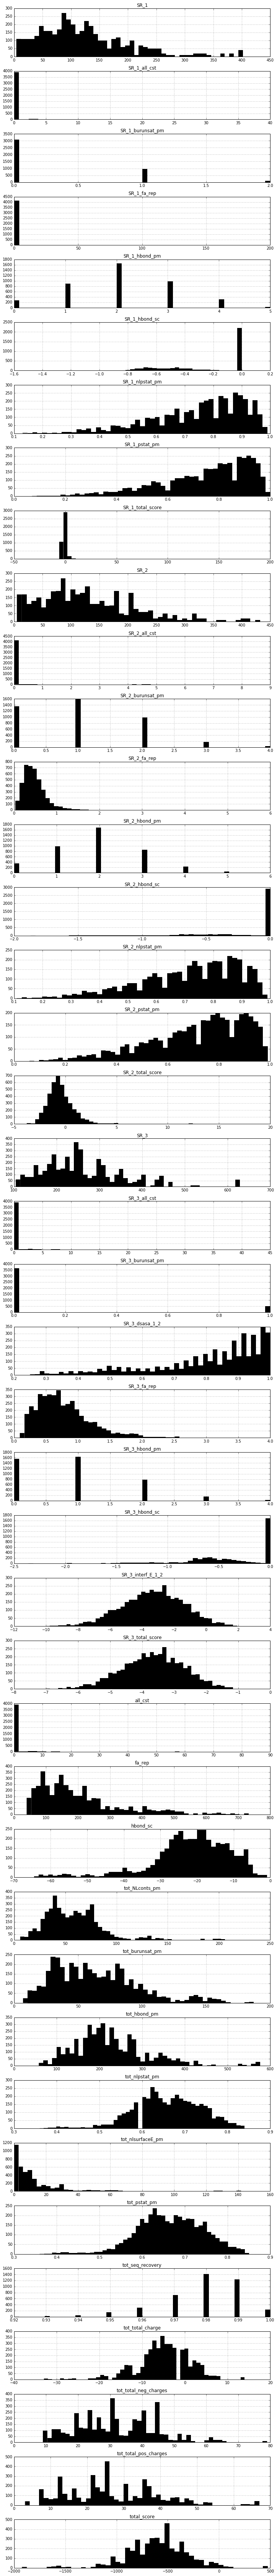

In [14]:
df.hist( linewidth=0, color='k', figsize=( 12, 120 ), bins=50, layout=(41,1) )

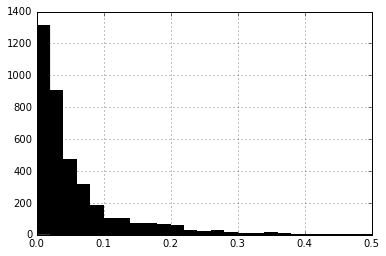

In [15]:
df.all_cst.hist( linewidth=0, color='k', bins=25, range=(0,.5) )

### Pull down the PDB files of the selected structures

In [16]:
# use this when working on local machine 

pull_list = [ 'dnh-aro/rosetta_runs/2nd_enzdes/out/{}.pdb\n'.format( i ) for i in filtered.description ]
with open( 'pull_list', 'w' ) as fn:
    fn.write( ''.join( pull_list ) )

#! head pull_list   
! rsync -avz --files-from=pull_list $ep:. . 

receiving file list ... done

sent 20 bytes  received 2413 bytes  4866.00 bytes/sec
total size is 14981924  speedup is 6157.80


## Manual curation of structures 

Now that we have run Rosetta simulations and picked a set of design critera to fiter by, it's time for manual curation of the structures. We'll download the 50 or so that look the best, and pick some designs to order. 

One thing that I really like to see when looking at a design is the mutations that were made when compared to the wild type enzyme. Let's diff the designs against their wild types (only those in the filtered list though).

Here, let's try to automate the curation step. Let's write a function that

+ takes a design PDB file name in enzdes/out

and makes a nice PyMOL session with 

+ the wild type loaded and overlayed 
+ mutations colored 

In [22]:
! ls ../match/hydratase.enzdes.cst

../match/hydratase.enzdes.cst


In [21]:
import os 
import string 
from shutil import copyfile

designs = pandas.read_csv( 'filtered.csv', index_col='match' ) 

for name, s in designs.iterrows():
    
    # create sandbox 
    sandbox_path = '{}_sandbox/'.format( name )
    if not os.path.exists( sandbox_path ):
        os.makedirs( sandbox_path )
    
    # construct paths 
    design_path = './dnh-aro/rosetta_runs/2nd_enzdes/out/{}.pdb'.format( s.description ) 
    wt_path = '../match/scaffold_set/{}_11.pdb'.format( s.scaffold )
    if os.path.exists( design_path ) and os.path.exists( wt_path ):
        
        # copy in files
        my_des = design_path.split( '/' )[-1]
        my_wt = '{}.pdb'.format( s.scaffold ) 
        
        copyfile( '../match/scaffold_set/{}_11.pdb'.format( s.scaffold ), sandbox_path + my_wt )
        copyfile( design_path, sandbox_path + my_des )
        copyfile( '../match/LG1.conf.pdb', sandbox_path + 'LG1.conf.pdb' )
        copyfile( '../match/LG1.params', sandbox_path + 'LG1.params' )
        copyfile( '../match/hydratase.enzdes.cst', sandbox_path + 'hydratase.enzdes.cst' )
        
        # get mutations 
        with open( sandbox_path + my_des ) as design:
            des_CA_lines = [ ln for ln in design.readlines() if 'ATOM' in ln and 'CA' in ln ]
            des_CA = [ ln.split()[3] for ln in des_CA_lines ]
            last_res = des_CA_lines[-1].split()[5]
            
        with open( sandbox_path + my_wt ) as wt:
            wt_CA = [ ln.split()[3] for ln in wt.readlines() if 'ATOM' in ln and 'CA' in ln ]
        
        d3 = [ '%s%s%s' % ( a1, i+1, a2 ) for i, ( a1, a2 ) in enumerate( zip( wt_CA, des_CA ) ) if a1 != a2 ]
        str_d3 = '+'.join( d3 ) 
        
        with open( '{}/{}.pml'.format( sandbox_path, name ), 'w' ) as fn:
            f = 'load {0}, {0}; load {1}, {1}; '.format( my_wt, my_des ) 
            resi = str_d3.translate( None, string.letters ) 
            g = 'sele muts, resi {} and obj {}; '.format( resi, my_des )  
            h = 'util.cbaw muts; util.cnc; orient muts; show sticks, organic; hide (hydro); remove solvent;'
            fn.write( f + g + h )
        
        with open( '{}/{}.puzzle_setup'.format( sandbox_path, name ), 'w' ) as fn:
            p1 = 'version: 1\n{{\n"backbone_locked": "{0}||"\n'.format( int( last_res ) + 1 ) 
            p2 = '"can_design": "1-{}||"\n}}\n'.format( last_res ) 
            fn.write( p1 + p2 )
            #'version: 1\n{\n"sidechain_locked": "%d||"\n"backbone_locked": "%d||"\n"can_design": "1-%d||"\n}\n' % ( int( last_res ) + 1, int( last_res ) + 1, last_res )
            
        with open( '{}/notes_template.txt'.format( sandbox_path ), 'w' ) as fn:
            lines = [ name, 'mutations: {}'.format( str_d3 ) ]
            for col, item in s.iteritems():
                lines.append( '{}: {}'.format( col, item ) )
            fn.writelines( [ ln + '\n' for ln in lines ] ) 

## Manually-curated designs 